In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import folium
%matplotlib notebook
token = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

# import get_canadian_weather_observations.py

Index(['Name', 'Province', 'Climate ID', 'Station ID', 'WMO ID', 'TC ID',
       'Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)', 'Latitude',
       'Longitude', 'Elevation (m)', 'First Year', 'Last Year',
       'HLY First Year', 'HLY Last Year', 'DLY First Year', 'DLY Last Year',
       'MLY First Year', 'MLY Last Year', 'Record Length'],
      dtype='object')
1410
count    1410.000000
mean       27.944681
std        23.338404
min         6.000000
25%        11.000000
50%        22.000000
75%        33.000000
max       177.000000
Name: Record Length, dtype: float64


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>


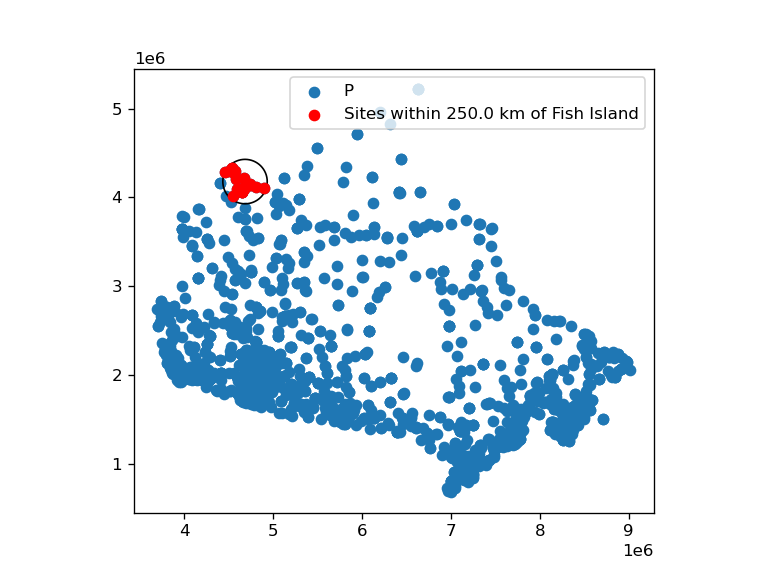

In [3]:
df = pd.read_csv('station_list/Station Inventory EN.csv',skiprows=3)
# print(df.columns)
df['Record Length'] = df['Last Year']-df['First Year']
# df = df.loc[((df['Latitude (Decimal Degrees)']>68)&(df['Longitude (Decimal Degrees)']<-125))] 
# # df = df.loc[((df['First Year']<=1990)&(df['Last Year']>=2019))] 
# df = df.loc[((df['Province']=='NORTHWEST TERRITORIES')|(df['Province']=='YUKON TERRITORY'))] 
df = df.loc[(df['Record Length']>5)] 
df = df.loc[np.isnan(df['HLY First Year'])==False] 
# HLY First Year
print(df.columns)
print(df['Name'].count())
print(df['Record Length'].describe())


Query = pd.DataFrame(data={'Site':['Fish Island'],'Longitude (Decimal Degrees)':[-134.857734],
                          'Latitude (Decimal Degrees)':[69.386080]})

gdfQuery = gpd.GeoSeries(index=Query['Site'].values,
        data=gpd.points_from_xy(Query['Longitude (Decimal Degrees)'],
                                Query['Latitude (Decimal Degrees)']
                               )
                                  )

gdf = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df['Longitude (Decimal Degrees)'],
                                df['Latitude (Decimal Degrees)']
                               )
                                  )
# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
gdfQuery.crs = WGS_1984
gdf.crs = WGS_1984

gdf = gdf.to_crs({'init': 'epsg:3347'})
gdfQuery = gdfQuery.to_crs({'init': 'epsg:3347'})

fig,ax=plt.subplots()
gdf.plot(ax=ax,label='P',legend=True)
Dist = 2.5e5#1e5
gdfQuery = gdfQuery.buffer(Dist)
gdfQuery.plot(ax=ax,label='Q',edgecolor='k',color=[0,0,0,0])


In = gdf.assign(**{key: gdf.within(geom) for key, geom in gdfQuery.items()})
# print(In)
In = In.loc[In['Fish Island']==True]
In.plot(color='r',ax=ax,legend=True,label='Sites within '+str(Dist*1e-3)+' km of Fish Island')

ax.legend()


In [4]:



# print(df.head())
Map = folium.Map(
    location=[69.386080,-134.857734], zoom_start=4, tiles=tileurl, attr='Mapbox')

point=folium.CircleMarker(
        location=[69.386080,-134.857734],
        radius=10,
        popup='Fish Island',
        fill_opacity = 1,
        fill=True,
        color='black',
        line_weight=.35,
        fill_color='green'
).add_to(Map)

for i,row in In.iterrows():
    point=folium.CircleMarker(
            location=[row['Latitude (Decimal Degrees)'],row['Longitude (Decimal Degrees)']],
            radius=5,
            popup=row['Name']+'\n'+str(row['Record Length']) +' '+str(row['First Year'])+' '+str(row['Last Year'])+\
        ' '+str(row['Station ID']),
            fill_opacity = 1,
            fill=True,
            color='black',
            line_weight=.35,
            fill_color='blue'
    ).add_to(Map)
Map

In [12]:
ID = In['Station ID']
! pip install progress
# for I in ID:
# print()
for I in ID:
#     print(I)
#     ! python get_canadian_weather_observations.py --daily -o /home/jupyter/Data {I}
    ! python get_canadian_weather_observations.py --hourly --start-date 1990-01 --end-date 2021-01 -o /home/jupyter/Data {I}
    

  Using cached progress-1.5-py3-none-any.whl
Directory does not exists 
	/home/jupyter/Data/10091/hourly
	Creating directory
Directory does not exists 
	/home/jupyter/Data/1699/hourly
	Creating directory
Directory does not exists 
	/home/jupyter/Data/1700/hourly
	Creating directory
Directory does not exists 
	/home/jupyter/Data/26987/hourly
	Creating directory
Directory does not exists 
	/home/jupyter/Data/10824/hourly
	Creating directory
Directory does not exists 
	/home/jupyter/Data/27620/hourly
	Creating directory


In [11]:

d='/home/jupyter/Data/'
Time='daily'
DT = 'Date/Time'
# Time = 'hourly'
# DT = 'Date/Time (LST)'
# p = 0
Data = {}
for j,row in In.iterrows():
    
    Dir = d+str(row['Station ID'])+'/'+Time

    for i,file in enumerate(os.listdir(Dir)):
        if i == 0:
            Temp = pd.read_csv(Dir+'/'+file,index_col=DT,parse_dates=True)
        else:
    #         Temp2 = pd.read_csv(Dir+'/'+file)
            Temp = Temp.append(pd.read_csv(Dir+'/'+file,index_col=DT,parse_dates=True))
    Temp = Temp.sort_index()
    Temp = Temp.loc[Temp.index.year>=1990]
    Temp = Temp.loc[((Temp.index.month>=5)&(Temp.index.month<=10))]
    Data[row['Station ID']]=Temp

<IPython.core.display.Javascript object>


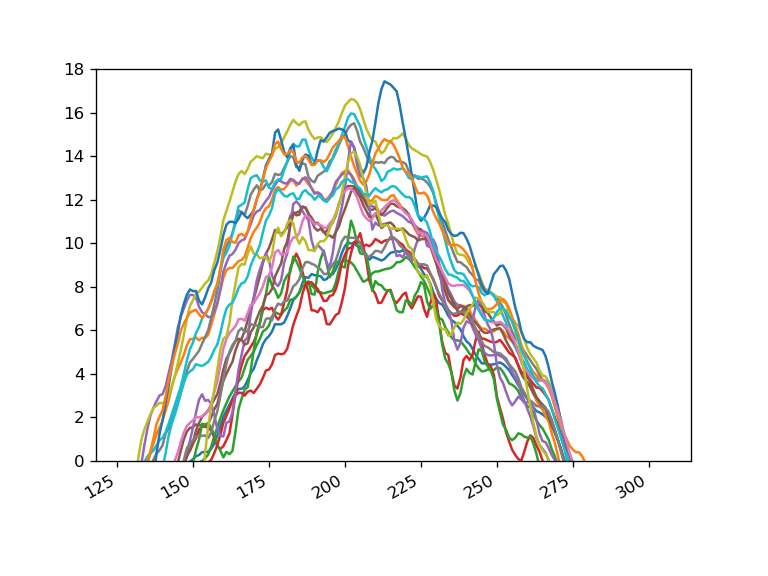

<ipython-input-7-872de8b032a5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mean_Temp[i]=np.nan
<ipython-input-7-872de8b032a5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mean_Temp[i] = Mean_Temp[i].fillna(Temp[Var])


            Station Name  Longitude (x)  Latitude (y)  Record Length  Last  \
1560     HERSCHEL ISLAND        -138.91         69.57             31  2021   
26869  IVVAVIK NAT. PARK        -140.15         69.16             26  2021   
10822      KOMAKUK BEACH        -140.20         69.61             24  2018   
1568     KOMAKUK BEACH A        -140.18         69.58              3  1993   
27296      MARGARET LAKE        -140.85         68.80             24  2021   
1596     SHINGLE POINT A        -137.22         68.95             31  2021   
1623           AKLAVIK A        -135.01         68.22             24  2014   
1648    FORT MCPHERSON A        -134.86         67.41             24  2014   
1669            INUVIK A        -133.48         68.30             16  2006   
31470      INUVIK AWOS A        -133.48         68.30              7  2013   
41883     INUVIK CLIMATE        -133.52         68.32             18  2021   
10091       PELLY ISLAND        -135.44         69.63           

In [7]:
if Time == 'hourly':
    Var = 'Temp (°C)'
else:
    Var = 'Mean Temp (°C)'
Thresh=.2
ID = []
MetaData = []
fig,ax = plt.subplots()

Mean_Temp = Data[10091][['Year','Month']]

for i in In['Station ID']:
    Temp = Data[i]
    Mean_Temp[i]=np.nan
    
    Mean_Temp[i] = Mean_Temp[i].fillna(Temp[Var])
    
    Count = Temp.resample('Y').count()
    Count['Comp'] = Count[Var]/Count['Year']
    
    L = (Count.index.year.max()-Count.index.year.min())
    
    Comp = Temp.count()
    RecComp = Comp[Var]/Comp['Year']
    MeanT = Temp[Var].mean()
    meta = []
    
    ID.append(i)
    for i in ['Station Name','Longitude (x)', 'Latitude (y)']:
        meta.append(Temp[i][0])
    meta.append(L)
    meta.append(Count.index.year.max())
    meta.append(Count.index.year.min())
    meta.append(RecComp)
    meta.append(MeanT)
    MetaData.append(meta)
    
    
#     Temp = Data[idx]
    Temp['DOY'] = Temp.index.dayofyear
    ax.plot(Temp.groupby('DOY').mean()[Var].rolling(7).mean())#,'Max Temp (°C)','Year']])
    # ax2 = plt.twinx()
    # ax2.plot(Temp.resample('Y').count()[Var]/Temp.resample('Y').count()['Year'],color='r')
ax.set_ylim(0,18)
fig.autofmt_xdate()
    
Temp = pd.DataFrame(index=ID,data=MetaData,columns=['Station Name',
                                                    'Longitude (x)', 'Latitude (y)','Record Length',
                                                    'Last','First',
                                                    'Record Completness','Mean Temp'])
# print(Temp)
print(Temp.loc[Temp['Record Completness']>Thresh])

In [8]:
print(Temp.columns)

if Time == 'Daily':
    Mean_Temp[41883]=Mean_Temp[41883].fillna(Mean_Temp[1669]).fillna(Mean_Temp[31470])
    Mean_Temp=Mean_Temp.drop([1669,31470],axis=1)

Mean_Temp[26987]=Mean_Temp[26987].fillna(Mean_Temp[1700]).fillna(Mean_Temp[1699])
Mean_Temp=Mean_Temp.drop([1700,1699],axis=1)
Mean_Temp=Mean_Temp.drop(['Year','Month'],axis=1)

# print(Mean_Temp)

# idx = 10091
# Temp = Data[idx]
# Temp['DOY'] = Temp.index.dayofyear
# fig = plt.figure()
# plt.plot(Temp.groupby('DOY').mean()['Mean Temp (°C)'])#,'Max Temp (°C)','Year']])
# # ax2 = plt.twinx()
# # ax2.plot(Temp.resample('Y').count()['Mean Temp (°C)']/Temp.resample('Y').count()['Year'],color='r')
# fig.autofmt_xdate()

Index(['Station Name', 'Longitude (x)', 'Latitude (y)', 'Record Length',
       'Last', 'First', 'Record Completness', 'Mean Temp'],
      dtype='object')


<ipython-input-8-7cd7bb28a331>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mean_Temp[41883]=Mean_Temp[41883].fillna(Mean_Temp[1669]).fillna(Mean_Temp[31470])


<IPython.core.display.Javascript object>


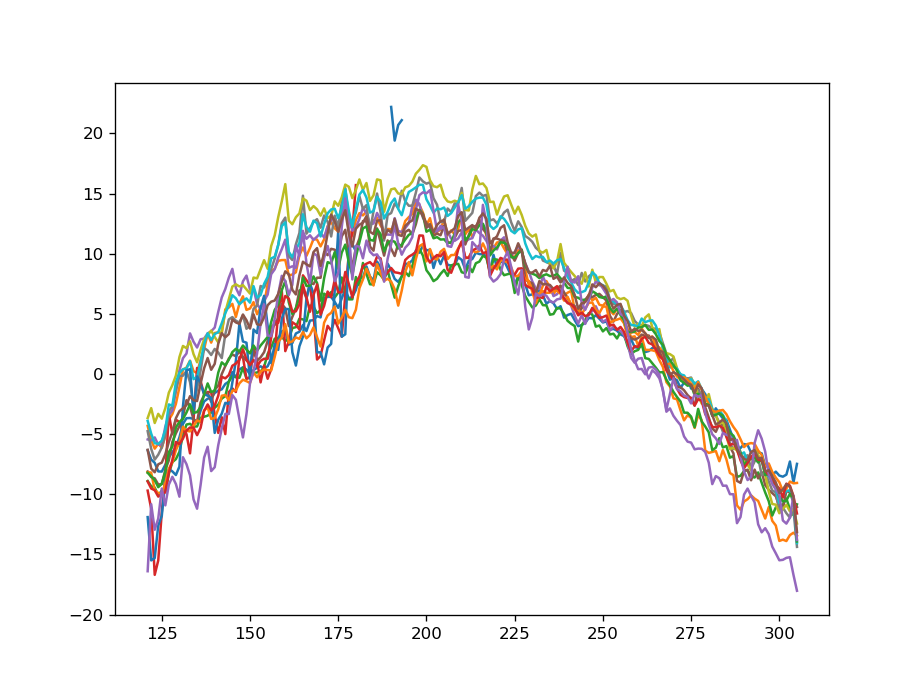

In [9]:
Year = (Mean_Temp.groupby(Mean_Temp.index.dayofyear).mean())
# print(Year)
fig,ax=plt.subplots()
for c in Year.columns:
    ax.plot(Year[c])

<IPython.core.display.Javascript object>


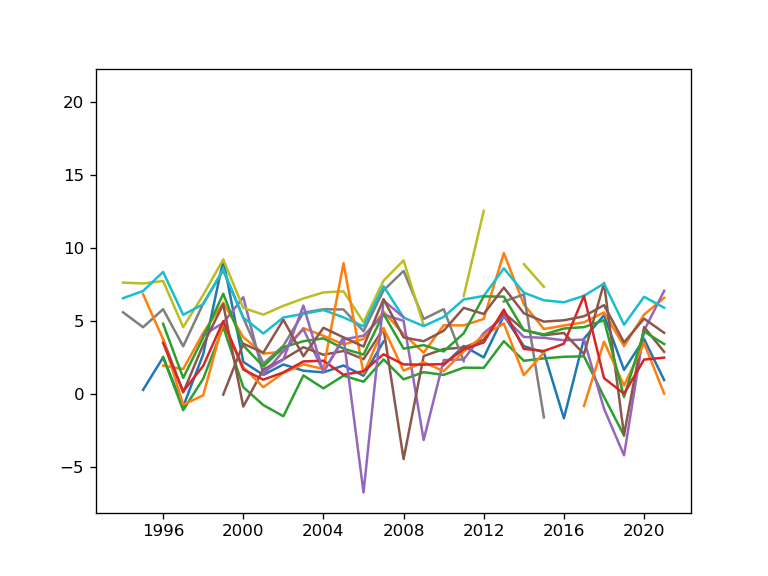

In [13]:
Year = (Mean_Temp.resample('Y').mean())

fig,ax=plt.subplots()
for c in Year.columns:
    ax.plot(Year[c])